# Imports

In [1183]:
import glob
import os
import sys
import pdb
import os.path as osp
sys.path.append(os.getcwd())

import numpy as np
import pickle as pk
from scipy.spatial.transform import Rotation as sRot
import matplotlib.pyplot as plt
import joblib
from uhc.utils.math_utils import smpl_op_to_op
from embodiedpose.models.humor.body_model.utils import smpl_to_openpose
from embodiedpose.models.humor.utils.humor_mujoco import SMPL_2_OP, OP_14_to_OP_12
from uhc.smpllib.smpl_parser import SMPL_Parser, SMPLH_BONE_ORDER_NAMES, SMPLH_Parser
import torch


data_dir = "data/smpl"
smpl_parser_n = SMPL_Parser(model_path=data_dir, gender="neutral")
smpl_parser_m = SMPL_Parser(model_path=data_dir, gender="male")
smpl_parser_f = SMPL_Parser(model_path=data_dir, gender="female")


def xyxy2xywh(bbox):
    x1, y1, x2, y2 = bbox

    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return [cx, cy, w, h]




smpl2op_map = smpl_to_openpose("smpl",
                                use_hands=False,
                                use_face=False,
                                use_face_contour=False,
                                openpose_format='coco25')
smpl_2op_submap = smpl2op_map[smpl2op_map < 22]


## Assmeble data fields

In [1184]:
base_path = "sample_data/"
res_data = pk.load(open(osp.join(base_path, 'res_wild/res.pk'), "rb"))
# res_data = pk.load(open(osp.join(base_path, 'res_dance/res.pk'), "rb"))

In [1185]:
res_data.keys()

dict_keys(['pred_uvd', 'pred_xyz_17', 'pred_xyz_29', 'pred_xyz_24_struct', 'pred_scores', 'pred_camera', 'pred_betas', 'pred_thetas', 'pred_phi', 'pred_cam_root', 'transl', 'transl_camsys', 'bbox', 'height', 'width', 'img_path'])

In [1186]:
pose_mat = np.array(res_data['pred_thetas'])
trans_orig = np.array(res_data['transl']).squeeze()
bbox = np.array(res_data['bbox']).squeeze()

B = pose_mat.shape[0]
pose_aa  = sRot.from_matrix(pose_mat.reshape(-1, 3, 3)).as_rotvec().reshape(B, -1)
pose_aa_orig = pose_aa.copy()

transform = sRot.from_euler('xyz', np.array([-np.pi / 2, 0, 0]), degrees=False)
new_root = (transform * sRot.from_rotvec(pose_aa[:, :3])).as_rotvec()
pose_aa[:, :3] = new_root
transform.as_matrix(), sRot.from_rotvec(pose_aa[0, :3]).as_matrix()
trans = trans_orig.dot(transform.as_matrix().T)
diff_trans = (trans[0, 2] - 0.92)
trans[:, 2] = trans[:, 2] - (trans[0, 2] - 0.92)

scale = (bbox[:, 2] - bbox[:, 0]) / 256
trans[:, 1] = trans[:, 1] / scale
beta = res_data['pred_betas'][0]


In [1187]:
kp_25  = np.zeros([B, 25, 3])
kp_25_idxes = np.arange(25)[SMPL_2_OP][OP_14_to_OP_12] # wow this needs to get better...

uv_29 = res_data['pred_uvd'][:, :24]
pts_12 =smpl_op_to_op(uv_29[:, smpl_2op_submap, :])
kp_25[:, kp_25_idxes] = pts_12

for i in range(B):
    bbox_xywh = xyxy2xywh(bbox[i])
    kp_25[i] = kp_25[i] * bbox_xywh[2]
    kp_25[i, :, 0] = kp_25[i, :, 0] + bbox_xywh[0]
    kp_25[i, :, 1] = kp_25[i, :, 1] + bbox_xywh[1]
    kp_25[i, :, 2] = 1 # probability


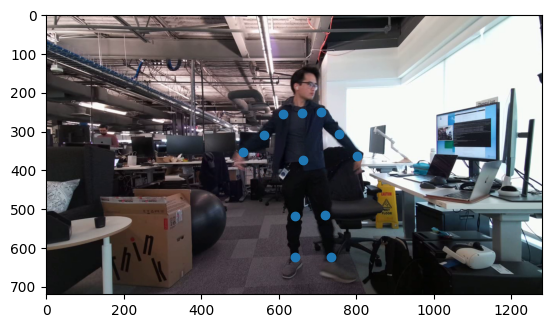

In [1188]:
idx = 100


pts = kp_25[:, SMPL_2_OP][..., OP_14_to_OP_12, :][idx]


im = plt.imread(osp.join(base_path, res_data['img_path'][idx]))
plt.scatter(pts[:, 0], pts[:, 1])
plt.imshow(im)


## Assemble camera 

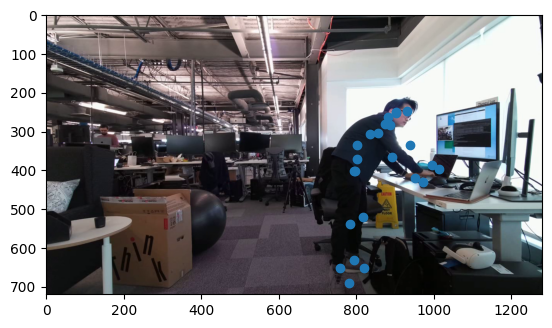

In [1189]:
idx = 50

height, width = res_data['height'][idx], res_data['width'][idx]
focal = 1000.0
bbox_xywh = xyxy2xywh(bbox[idx])
focal = focal / 256 * bbox_xywh[2]
focal = (2 * focal / min(height, width))

full_R = sRot.from_euler("xyz", np.array([np.pi/2, 0, 0])).as_matrix()
full_t = np.array([0,  -diff_trans,  0])
K =  np.array([[            res_data['height'][0]/2 * (focal/scale[idx]),      0,  res_data['width'][0]/2 ],
               [   0.              ,      res_data['height'][0]/2 * (focal/scale[idx]), res_data['height'][0]/2],
               [   0.              ,      0,           1.              ]])


cam = {
    "full_R": full_R, 
    "full_t": full_t, 
    "K": K,
    'img_w': res_data['width'][0],
     'img_h': res_data['height'][0],
     'scene_name': None
}

with torch.no_grad():
    _, jts = smpl_parser_n.get_joints_verts(torch.from_numpy(pose_aa[idx:idx+1]), torch.from_numpy(beta[None, ]), th_trans = torch.from_numpy(trans[idx:idx + 1]))
    
pred_joints3d = jts @ full_R.T + full_t
pred_joints2d = pred_joints3d @ (K.T)
z = pred_joints2d[:, :, 2:]
pred_joints2d = pred_joints2d[:, :, :2] / z

im = plt.imread(osp.join(base_path, res_data['img_path'][idx]))
plt.imshow(im)
plt.scatter(pred_joints2d[..., 0], pred_joints2d[..., 1])
# plt.scatter(pred_joints2d[:, :5, 0], pred_joints2d[:, :5, 1])



## HyberIK Study

In [1190]:
# idx = 50

# _, jts_zero = smpl_parser_n.get_joints_verts(torch.zeros((1, 72)))

# trans_fix = torch.from_numpy(trans_orig[idx:idx + 1]) - jts_zero[0, 0]
# with torch.no_grad():
#     vertices, jts = smpl_parser_n.get_joints_verts(torch.from_numpy(pose_aa_orig[idx:idx+1]), torch.from_numpy(beta[None, ]), th_trans = trans_fix)
    
# z_rot = sRot.from_euler('xyz', np.array([0, 0, np.pi])).as_matrix()
# vertices = vertices @ z_rot
# pred_joints3d = vertices 
# pred_joints3d[..., :2] *= 5.5165

# z = pred_joints3d[:, :, 2:]
# pred_joints3d= pred_joints3d[:, :, :2] / z

# pred_joints2d = pred_joints3d.clone()
# pred_joints2d[..., 0] = (pred_joints3d[..., 0] * -360 + 640)
# pred_joints2d[..., 1] = (pred_joints3d[..., 1] * -360 + 360)

# im = plt.imread(osp.join(base_path, res_data['img_path'][idx]))
# plt.imshow(im)
# plt.scatter(pred_joints2d[..., 0], pred_joints2d[..., 1], s = 0.1)




In [1191]:
pose_mat = sRot.from_rotvec(pose_aa.reshape(B * 24, 3)).as_matrix().reshape(B, 24, 3, 3)
pose_body = pose_mat[:, 1:22]
root_orient = pose_mat[:, 0:1]
new_dict = {}
start = 0
end = B
key = '00'
new_dict[key] = {
    "joints2d": kp_25[start:end].copy(),
    "pose_body": pose_body[start:end], 
    "root_orient": root_orient[start:end],
    "trans": trans.squeeze()[start:end],
    "pose_aa" : pose_aa.reshape(-1, 72)[start:end],
    "joints": np.zeros([B, 22, 3]),
    "seq_name": "01",
    "pose_6d": np.zeros([B, 24, 6]), 
    'betas': beta,
    "gender": "neutral", 
    "seq_name": key,
    "trans_vel": np.zeros([B, 1, 3]), 
    "joints_vel": np.zeros([B, 22, 3]), 
    "root_orient_vel": np.zeros([B, 1, 3]), 
    "points3d": None,
    "cam": cam
}
joblib.dump(new_dict, "sample_data/wild_processed.pkl")

['sample_data/wild_processed.pkl']